# Imports

In [1]:
import os
import ipdb
import argparse
import numpy as np
import pandas as pd
import numpy.random as random
from progressbar import ProgressBar
import matplotlib.pyplot as plt
import gzip
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import json
pd.options.display.max_columns = 9999999

In [3]:
data = []

with gzip.open('movielens_5_injected_H50.json.gz', 'rt', encoding='utf-16') as f:
    for line in f:
        data.append(json.loads(line))

In [4]:
len(data)

105000

In [5]:
print(data[0])
print(data[1])
print(data[2])
print(data[3])
print(data[4])

{'t': 874724710, 'u': 'bottom_255', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 50, 'bip': True, 'cost': 0.0}
{'t': 874724727, 'u': 'bottom_286', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 50, 'bip': True, 'cost': 0.0}
{'t': 874724754, 'u': 'bottom_298', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 50, 'bip': True, 'cost': 0.0}
{'t': 874724781, 'u': 'bottom_185', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 50, 'bip': True, 'cost': 0.0}
{'t': 874724843, 'u': 'bottom_173', 'v': 'top_259', 'is_fraud': 0, 'history_type': 'H', 'history_size': 50, 'bip': True, 'cost': 0.0}


# Flatten the internal `O(1)` features

In [6]:
from utilitiesMe import flatten_dict

In [7]:
data_flattened = []
for row in data:
    data_flattened.append(flatten_dict(row))

In [8]:
data_flattened[0]

{'t': 874724710,
 'u': 'bottom_255',
 'v': 'top_259',
 'is_fraud': 0,
 'history_type': 'H',
 'history_size': 50,
 'bip': True,
 'cost': 0.0}

# Convert flattened json to dataframe

In [9]:
df = pd.DataFrame.from_dict(data_flattened, orient='columns')

In [10]:
df

,t,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,H,50,True,0.0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,35.0,14.0,1.0,0.0,1.0,35.0,14.0,1.0,14.0,40.0,1.0,5.0,1.0,1.0,14.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104996,893286638,bottom_328,top_729,0,H,50,True,0.0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,34.0,15.0,1.0,0.0,1.0,34.0,15.0,1.0,15.0,40.0,1.0,5.0,1.0,1.0,15.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104997,893286638,bottom_333,top_729,0,H,50,True,0.0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,33.0,16.0,1.0,0.0,1.0,33.0,16.0,1.0,16.0,40.0,1.0,5.0,1.0,1.0,16.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104998,893286638,bottom_689,top_729,0,H,50,True,0.0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,32.0,17.0,1.0,0.0,1.0,32.0,17.0,1.0,17.0,40.0,1.0,5.0,1.0,1.0,17.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


In [11]:
df.rename(columns={'t': 'timestamp'}, inplace=True)
df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,H,50,True,0.0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,35.0,14.0,1.0,0.0,1.0,35.0,14.0,1.0,14.0,40.0,1.0,5.0,1.0,1.0,14.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104996,893286638,bottom_328,top_729,0,H,50,True,0.0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,34.0,15.0,1.0,0.0,1.0,34.0,15.0,1.0,15.0,40.0,1.0,5.0,1.0,1.0,15.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104997,893286638,bottom_333,top_729,0,H,50,True,0.0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,33.0,16.0,1.0,0.0,1.0,33.0,16.0,1.0,16.0,40.0,1.0,5.0,1.0,1.0,16.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104998,893286638,bottom_689,top_729,0,H,50,True,0.0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,32.0,17.0,1.0,0.0,1.0,32.0,17.0,1.0,17.0,40.0,1.0,5.0,1.0,1.0,17.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


In [12]:
df.describe()

,timestamp,is_fraud,history_size,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,1.050000e+05,105000.000000,105000.0,105000.000000,104950.000000,104950.000000,104950.000000,104950.0,104950.000000,104950.0,104950.000000,104950.000000,104950.0,104950.000000,104950.0,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.00000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.00000,104950.000000,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0
mean,8.835258e+08,0.047619,50.0,0.000003,49.146632,48.315684,0.808928,1.0,1.417742,1.0,48.315684,0.808928,1.0,1.417742,1.0,5.067508,2.686946,0.189824,3.202096,35.434302,4.741896,2.686946,0.189824,3.202096,35.434302,4.741896,1.041229,27.438971,46.674045,1.251062,0.71697,0.641153,1.041229,27.438971,46.674045,1.251062,0.71697,0.641153,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
std,5.345223e+06,0.212960,0.0,0.000199,1.458411,2.851474,1.355754,0.0,0.532611,0.0,2.851474,1.355754,0.0,0.532611,0.0,2.451249,1.765194,0.484525,9.506032,10.830486,9.934895,1.765194,0.484525,9.506032,10.830486,9.934895,0.206161,17.336261,9.313362,0.918533,1.28331,1.019540,0.206161,17.336261,9.313362,0.918533,1.28331,1.019540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,8.747247e+08,0.000000,50.0,0.000000,37.000000,24.000000,0.000000,1.0,1.000000,1.0,24.000000,0.000000,1.0,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,8.000000,1.000000,0.000000,0.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
25%,8.794484e+08,0.000000,50.0,0.000000,49.000000,48.000000,0.000000,1.0,1.000000,1.0,48.000000,0.000000,1.0,1.000000,1.0,3.000000,1.000000,0.000000,1.000000,26.000000,1.000000,1.000000,0.000000,1.000000,26.000000,1.000000,1.000000,11.000000,48.000000,1.000000,0.00000,0.000000,1.000000,11.000000,48.000000,1.000000,0.00000,0.000000,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
50%,8.828265e+08,0.000000,50.0,0.000000,50.000000,50.000000,0.000000,1.0,1.000000,1.0,50.000000,0.000000,1.0,1.000000,1.0,5.000000,2.000000,0.000000,1.000000,36.000000,1.000000,2.000000,0.000000,1.000000,36.000000,1.000000,1.000000,28.000000,50.000000,1.000000,0.00000,0.000000,1.000000,28.000000,50.000000,1.000000,0.00000,0.000000,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
75%,8.882664e+08,0.000000,50.0,0.000000,50.000000,50.000000,1.000000,1.0,2.000000,1.0,50.000000,1.000000,1.0,2.000000,1.0,6.000000,4.000000,0.000000,1.000000,46.000000,3.000000,4.000000,0.000000,1.000000,46.000000,3.000000,1.000000,46.000000,50.000000,1.000000,1.00000,1.000000,1.000000,46.000000,50.000000,1.000000,1.00000,1.000000,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
max,8.932866e+08,1.000000,50.0,0.015625,50.000000,50.000000,13.000000,1.0,4.000000,1.0,50.000000,13.000000,1.0,4.000000,1.0,20.000000,12.000000,6.000000,50.000000,50.000000,50.000000,12.000000,6.000000,50.000000,50.000000,50.000000,4.000000,50.00

# Remove NaNs

In [13]:
df.head(10)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,874724882,bottom_108,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,874724882,bottom_772,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,874724905,bottom_288,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,874724937,bottom_928,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,874724988,bottom_117,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Create a new DataFrame to preserve rows with NaN
nan_df = pd.DataFrame(columns=df.columns)

# Remove rows with NaN from 'df' and append them to 'nan_df'
nan_rows = df[df.isnull().any(axis=1)]
df = df.dropna()
nan_df = nan_df.append(nan_rows)

# Display the updated 'df' and 'nan_df'
print("Updated DataFrame without NaN:")
df

Updated DataFrame without NaN:


,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
50,874729995,bottom_174,top_712,0,H,50,True,0.0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,25.0,15.0,0.0,0.0,10.0,25.0,15.0,1.0,25.0,48.0,1.0,1.0,0.0,1.0,25.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
51,874729995,bottom_692,top_712,0,H,50,True,0.0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,26.0,14.0,0.0,0.0,10.0,26.0,14.0,1.0,26.0,48.0,1.0,1.0,0.0,1.0,26.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
52,874729995,bottom_99,top_712,0,H,50,True,0.0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,27.0,13.0,0.0,0.0,10.0,27.0,13.0,1.0,27.0,48.0,1.0,1.0,0.0,1.0,27.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
53,874729996,bottom_1220,top_712,0,H,50,True,0.0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,28.0,12.0,0.0,0.0,10.0,28.0,12.0,1.0,28.0,48.0,1.0,1.0,0.0,1.0,28.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
54,874729996,bottom_392,top_712,0,H,50,True,0.0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,10.0,29.0,11.0,0.0,0.0,10.0,29.0,11.0,1.0,29.0,50.0,1.0,0.0,0.0,1.0,29.0,50.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,893286638,bottom_313,top_729,0,H,50,True,0.0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,35.0,14.0,1.0,0.0,1.0,35.0,14.0,1.0,14.0,40.0,1.0,5.0,1.0,1.0,14.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104996,893286638,bottom_328,top_729,0,H,50,True,0.0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,34.0,15.0,1.0,0.0,1.0,34.0,15.0,1.0,15.0,40.0,1.0,5.0,1.0,1.0,15.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104997,893286638,bottom_333,top_729,0,H,50,True,0.0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,33.0,16.0,1.0,0.0,1.0,33.0,16.0,1.0,16.0,40.0,1.0,5.0,1.0,1.0,16.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104998,893286638,bottom_689,top_729,0,H,50,True,0.0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,32.0,17.0,1.0,0.0,1.0,32.0,17.0,1.0,17.0,40.0,1.0,5.0,1.0,1.0,17.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


In [15]:
nan_df

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,874724710,bottom_255,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,874724727,bottom_286,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,874724754,bottom_298,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,874724781,bottom_185,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,874724843,bottom_173,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,874724882,bottom_108,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,874724882,bottom_772,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,874724905,bottom_288,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,874724937,bottom_928,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,874724988,bottom_117,top_259,0,H,50,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df.describe()

,timestamp,is_fraud,history_size,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,1.049500e+05,104950.000000,104950.0,104950.000000,104950.000000,104950.000000,104950.000000,104950.0,104950.000000,104950.0,104950.000000,104950.000000,104950.0,104950.000000,104950.0,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.00000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.00000,104950.000000,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0
mean,8.835300e+08,0.047642,50.0,0.000003,49.146632,48.315684,0.808928,1.0,1.417742,1.0,48.315684,0.808928,1.0,1.417742,1.0,5.067508,2.686946,0.189824,3.202096,35.434302,4.741896,2.686946,0.189824,3.202096,35.434302,4.741896,1.041229,27.438971,46.674045,1.251062,0.71697,0.641153,1.041229,27.438971,46.674045,1.251062,0.71697,0.641153,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
std,5.343044e+06,0.213008,0.0,0.000199,1.458411,2.851474,1.355754,0.0,0.532611,0.0,2.851474,1.355754,0.0,0.532611,0.0,2.451249,1.765194,0.484525,9.506032,10.830486,9.934895,1.765194,0.484525,9.506032,10.830486,9.934895,0.206161,17.336261,9.313362,0.918533,1.28331,1.019540,0.206161,17.336261,9.313362,0.918533,1.28331,1.019540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,8.747300e+08,0.000000,50.0,0.000000,37.000000,24.000000,0.000000,1.0,1.000000,1.0,24.000000,0.000000,1.0,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,8.000000,1.000000,0.000000,0.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
25%,8.794488e+08,0.000000,50.0,0.000000,49.000000,48.000000,0.000000,1.0,1.000000,1.0,48.000000,0.000000,1.0,1.000000,1.0,3.000000,1.000000,0.000000,1.000000,26.000000,1.000000,1.000000,0.000000,1.000000,26.000000,1.000000,1.000000,11.000000,48.000000,1.000000,0.00000,0.000000,1.000000,11.000000,48.000000,1.000000,0.00000,0.000000,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
50%,8.828269e+08,0.000000,50.0,0.000000,50.000000,50.000000,0.000000,1.0,1.000000,1.0,50.000000,0.000000,1.0,1.000000,1.0,5.000000,2.000000,0.000000,1.000000,36.000000,1.000000,2.000000,0.000000,1.000000,36.000000,1.000000,1.000000,28.000000,50.000000,1.000000,0.00000,0.000000,1.000000,28.000000,50.000000,1.000000,0.00000,0.000000,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
75%,8.882666e+08,0.000000,50.0,0.000000,50.000000,50.000000,1.000000,1.0,2.000000,1.0,50.000000,1.000000,1.0,2.000000,1.0,6.000000,4.000000,0.000000,1.000000,46.000000,3.000000,4.000000,0.000000,1.000000,46.000000,3.000000,1.000000,46.000000,50.000000,1.000000,1.00000,1.000000,1.000000,46.000000,50.000000,1.000000,1.00000,1.000000,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
max,8.932866e+08,1.000000,50.0,0.015625,50.000000,50.000000,13.000000,1.0,4.000000,1.0,50.000000,13.000000,1.0,4.000000,1.0,20.000000,12.000000,6.000000,50.000000,50.000000,50.000000,12.000000,6.000000,50.000000,50.000000,50.000000,4.000000,50.00

In [17]:
df_features = df.drop(["timestamp",
                       "u",
                       "v", 
                        "history_type", 
                        "bip", 
                        "cost", # cost of O1 features
                        "history_size"], axis="columns")
df_features

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
50,0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,25.0,15.0,0.0,0.0,10.0,25.0,15.0,1.0,25.0,48.0,1.0,1.0,0.0,1.0,25.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
51,0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,26.0,14.0,0.0,0.0,10.0,26.0,14.0,1.0,26.0,48.0,1.0,1.0,0.0,1.0,26.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
52,0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,27.0,13.0,0.0,0.0,10.0,27.0,13.0,1.0,27.0,48.0,1.0,1.0,0.0,1.0,27.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
53,0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,28.0,12.0,0.0,0.0,10.0,28.0,12.0,1.0,28.0,48.0,1.0,1.0,0.0,1.0,28.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
54,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,10.0,29.0,11.0,0.0,0.0,10.0,29.0,11.0,1.0,29.0,50.0,1.0,0.0,0.0,1.0,29.0,50.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,35.0,14.0,1.0,0.0,1.0,35.0,14.0,1.0,14.0,40.0,1.0,5.0,1.0,1.0,14.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104996,0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,34.0,15.0,1.0,0.0,1.0,34.0,15.0,1.0,15.0,40.0,1.0,5.0,1.0,1.0,15.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104997,0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,33.0,16.0,1.0,0.0,1.0,33.0,16.0,1.0,16.0,40.0,1.0,5.0,1.0,1.0,16.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104998,0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,32.0,17.0,1.0,0.0,1.0,32.0,17.0,1.0,17.0,40.0,1.0,5.0,1.0,1.0,17.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


In [18]:
df_features.describe()

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
count,104950.000000,104950.000000,104950.000000,104950.000000,104950.0,104950.000000,104950.0,104950.000000,104950.000000,104950.0,104950.000000,104950.0,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.00000,104950.000000,104950.000000,104950.000000,104950.000000,104950.000000,104950.00000,104950.000000,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0,104950.0
mean,0.047642,49.146632,48.315684,0.808928,1.0,1.417742,1.0,48.315684,0.808928,1.0,1.417742,1.0,5.067508,2.686946,0.189824,3.202096,35.434302,4.741896,2.686946,0.189824,3.202096,35.434302,4.741896,1.041229,27.438971,46.674045,1.251062,0.71697,0.641153,1.041229,27.438971,46.674045,1.251062,0.71697,0.641153,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
std,0.213008,1.458411,2.851474,1.355754,0.0,0.532611,0.0,2.851474,1.355754,0.0,0.532611,0.0,2.451249,1.765194,0.484525,9.506032,10.830486,9.934895,1.765194,0.484525,9.506032,10.830486,9.934895,0.206161,17.336261,9.313362,0.918533,1.28331,1.019540,0.206161,17.336261,9.313362,0.918533,1.28331,1.019540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,37.000000,24.000000,0.000000,1.0,1.000000,1.0,24.000000,0.000000,1.0,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,8.000000,1.000000,0.000000,0.000000,1.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,1.000000,1.000000,1.000000,1.000000,0.00000,0.000000,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
25%,0.000000,49.000000,48.000000,0.000000,1.0,1.000000,1.0,48.000000,0.000000,1.0,1.000000,1.0,3.000000,1.000000,0.000000,1.000000,26.000000,1.000000,1.000000,0.000000,1.000000,26.000000,1.000000,1.000000,11.000000,48.000000,1.000000,0.00000,0.000000,1.000000,11.000000,48.000000,1.000000,0.00000,0.000000,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
50%,0.000000,50.000000,50.000000,0.000000,1.0,1.000000,1.0,50.000000,0.000000,1.0,1.000000,1.0,5.000000,2.000000,0.000000,1.000000,36.000000,1.000000,2.000000,0.000000,1.000000,36.000000,1.000000,1.000000,28.000000,50.000000,1.000000,0.00000,0.000000,1.000000,28.000000,50.000000,1.000000,0.00000,0.000000,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
75%,0.000000,50.000000,50.000000,1.000000,1.0,2.000000,1.0,50.000000,1.000000,1.0,2.000000,1.0,6.000000,4.000000,0.000000,1.000000,46.000000,3.000000,4.000000,0.000000,1.000000,46.000000,3.000000,1.000000,46.000000,50.000000,1.000000,1.00000,1.000000,1.000000,46.000000,50.000000,1.000000,1.00000,1.000000,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
max,1.000000,50.000000,50.000000,13.000000,1.0,4.000000,1.0,50.000000,13.000000,1.0,4.000000,1.0,20.000000,12.000000,6.000000,50.000000,50.000000,50.000000,12.000000,6.000000,50.000000,50.000000,50.000000,4.000000,50.000000,50.000000,12.000000,12.00000,10.000000,4.000000,50.000000,50.000000,12.000000,12.00000,10.000000,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


In [19]:
df_target = df["is_fraud"]
df_target

50        0
51        0
52        0
53        0
54        0
         ..
104995    0
104996    0
104997    0
104998    0
104999    0
Name: is_fraud, Length: 104950, dtype: int64

# Learning Technique #1: Classical + Underasmpling in training only

## $r$ = 0.7
Before undersampling, take 30% for testing then the 70% take it for training and do undersampling on it

In [20]:
percentage=round(len(df)/100*70) 
train_df=df_features.head(percentage)
test_df=df_features.iloc[percentage:len(df_features),:]

In [21]:
len(train_df) + len(test_df) == len(df)

True

In [22]:
train_df

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
50,0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,25.0,15.0,0.0,0.0,10.0,25.0,15.0,1.0,25.0,48.0,1.0,1.0,0.0,1.0,25.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
51,0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,26.0,14.0,0.0,0.0,10.0,26.0,14.0,1.0,26.0,48.0,1.0,1.0,0.0,1.0,26.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
52,0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,27.0,13.0,0.0,0.0,10.0,27.0,13.0,1.0,27.0,48.0,1.0,1.0,0.0,1.0,27.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
53,0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,28.0,12.0,0.0,0.0,10.0,28.0,12.0,1.0,28.0,48.0,1.0,1.0,0.0,1.0,28.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
54,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,10.0,29.0,11.0,0.0,0.0,10.0,29.0,11.0,1.0,29.0,50.0,1.0,0.0,0.0,1.0,29.0,50.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73510,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,4.0,2.0,0.0,1.0,39.0,1.0,2.0,0.0,1.0,39.0,1.0,1.0,1.0,50.0,2.0,0.0,2.0,1.0,1.0,50.0,2.0,0.0,2.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
73511,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,38.0,2.0,1.0,1.0,1.0,38.0,2.0,1.0,2.0,50.0,1.0,0.0,2.0,1.0,2.0,50.0,1.0,0.0,2.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
73512,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,38.0,2.0,1.0,1.0,1.0,38.0,2.0,1.0,38.0,50.0,1.0,0.0,0.0,1.0,38.0,50.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
73513,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,38.0,2.0,1.0,1.0,1.0,38.0,2.0,1.0,38.0,50.0,1.0,0.0,0.0,1.0,38.0,50.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


In [23]:
test_df

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
73515,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,37.0,3.0,1.0,0.0,1.0,37.0,3.0,1.0,37.0,50.0,1.0,0.0,0.0,1.0,37.0,50.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
73516,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,37.0,3.0,1.0,0.0,1.0,37.0,3.0,1.0,37.0,50.0,1.0,0.0,0.0,1.0,37.0,50.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
73517,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,37.0,3.0,1.0,0.0,1.0,37.0,3.0,1.0,37.0,50.0,1.0,0.0,0.0,1.0,37.0,50.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
73518,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,37.0,3.0,1.0,0.0,1.0,37.0,3.0,1.0,37.0,50.0,1.0,0.0,0.0,1.0,37.0,50.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
73519,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,37.0,3.0,1.0,0.0,1.0,37.0,3.0,1.0,37.0,50.0,1.0,0.0,0.0,1.0,37.0,50.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,35.0,14.0,1.0,0.0,1.0,35.0,14.0,1.0,14.0,40.0,1.0,5.0,1.0,1.0,14.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104996,0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,34.0,15.0,1.0,0.0,1.0,34.0,15.0,1.0,15.0,40.0,1.0,5.0,1.0,1.0,15.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104997,0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,33.0,16.0,1.0,0.0,1.0,33.0,16.0,1.0,16.0,40.0,1.0,5.0,1.0,1.0,16.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104998,0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,32.0,17.0,1.0,0.0,1.0,32.0,17.0,1.0,17.0,40.0,1.0,5.0,1.0,1.0,17.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


### Undersampling and training on `X_train, y_train`

In [24]:
train_df["is_fraud"].value_counts()

0    69974
1     3491
Name: is_fraud, dtype: int64

In [25]:
# Separating the data for analysis (they will be Series)
nonanomalous = train_df[train_df.is_fraud == 0]
anomalous = train_df[train_df.is_fraud == 1]

In [26]:
print(len(nonanomalous))
print(len(anomalous))

69974
3491


In [27]:
print(nonanomalous.shape)
print(anomalous.shape)

(69974, 45)
(3491, 45)


In [28]:
# Compare the values for both classes
train_df.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,49.191771,48.405436,0.765041,1.0,1.409538,1.0,48.405436,0.765041,1.0,1.409538,1.0,4.907280,2.599080,0.171992,3.423043,35.760054,4.988181,2.599080,0.171992,3.423043,35.760054,4.988181,1.039729,28.981179,46.804356,1.116329,0.682353,0.531640,1.039729,28.981179,46.804356,1.116329,0.682353,0.531640,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
1,49.190776,48.403609,0.765110,1.0,1.422229,1.0,48.403609,0.765110,1.0,1.422229,1.0,6.047837,3.732168,0.177886,1.000286,34.652249,1.696649,3.732168,0.177886,1.000286,34.652249,1.696649,1.027786,1.043254,47.181037,3.722429,0.731882,2.307362,1.027786,1.043254,47.181037,3.722429,0.731882,2.307362,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


In [29]:
# Sampling
nonanomalous_sample = nonanomalous.sample(n = len(anomalous), random_state=12)

In [30]:
# Concatenating
new_dataset = pd.concat([nonanomalous_sample, anomalous], axis=0)

In [31]:
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
720,0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,41.0,8.0,1.0,0.0,1.0,41.0,8.0,1.0,8.0,48.0,1.0,1.0,1.0,1.0,8.0,48.0,1.0,1.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
41982,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,48.0,1.0,2.0,0.0,1.0,48.0,1.0,1.0,48.0,50.0,1.0,0.0,0.0,1.0,48.0,50.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
69060,0,48.0,46.0,2.0,1.0,2.0,1.0,46.0,2.0,1.0,2.0,1.0,5.0,2.0,2.0,1.0,44.0,2.0,2.0,2.0,1.0,44.0,2.0,1.0,44.0,46.0,1.0,2.0,0.0,1.0,44.0,46.0,1.0,2.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
29178,0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,4.0,1.0,1.0,1.0,33.0,2.0,1.0,1.0,1.0,33.0,2.0,2.0,14.0,5.0,1.0,0.0,1.0,2.0,14.0,5.0,1.0,0.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
34400,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,7.0,4.0,0.0,1.0,20.0,1.0,4.0,0.0,1.0,20.0,1.0,1.0,14.0,50.0,1.0,0.0,1.0,1.0,14.0,50.0,1.0,0.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73386,1,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,48.0,1.0,2.0,0.0,1.0,48.0,1.0,1.0,1.0,50.0,2.0,0.0,1.0,1.0,1.0,50.0,2.0,0.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
73396,1,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,4.0,3.0,0.0,1.0,47.0,1.0,3.0,0.0,1.0,47.0,1.0,1.0,1.0,50.0,3.0,0.0,1.0,1.0,1.0,50.0,3.0,0.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
73408,1,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,5.0,4.0,0.0,1.0,46.0,1.0,4.0,0.0,1.0,46.0,1.0,1.0,1.0,50.0,4.0,0.0,1.0,1.0,1.0,50.0,4.0,0.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
73444,1,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,9.0,6.0,0.0,1.0,19.0,1.0,6.0,0.0,1.0,19.0,1.0,1.0,1.0,48.0,6.0,1.0,3.0,1.0,1.0,48.0,6.0,1.0,3.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


Author: Now the rows of the `nonanomalous` are random

In [32]:
# Now we will check deeper the values on the new dataset and compare them
new_dataset["is_fraud"].value_counts()

0    3491
1    3491
Name: is_fraud, dtype: int64

In [33]:
new_dataset.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,49.164709,48.354913,0.784875,1.0,1.423088,1.0,48.354913,0.784875,1.0,1.423088,1.0,4.883128,2.559439,0.166428,3.368089,35.615296,4.957605,2.559439,0.166428,3.368089,35.615296,4.957605,1.044686,28.935262,46.508737,1.121169,0.695503,0.531653,1.044686,28.935262,46.508737,1.121169,0.695503,0.531653,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
1,49.190776,48.403609,0.765110,1.0,1.422229,1.0,48.403609,0.765110,1.0,1.422229,1.0,6.047837,3.732168,0.177886,1.000286,34.652249,1.696649,3.732168,0.177886,1.000286,34.652249,1.696649,1.027786,1.043254,47.181037,3.722429,0.731882,2.307362,1.027786,1.043254,47.181037,3.722429,0.731882,2.307362,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


In [34]:
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
720,0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,41.0,8.0,1.0,0.0,1.0,41.0,8.0,1.0,8.0,48.0,1.0,1.0,1.0,1.0,8.0,48.0,1.0,1.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
41982,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,48.0,1.0,2.0,0.0,1.0,48.0,1.0,1.0,48.0,50.0,1.0,0.0,0.0,1.0,48.0,50.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
69060,0,48.0,46.0,2.0,1.0,2.0,1.0,46.0,2.0,1.0,2.0,1.0,5.0,2.0,2.0,1.0,44.0,2.0,2.0,2.0,1.0,44.0,2.0,1.0,44.0,46.0,1.0,2.0,0.0,1.0,44.0,46.0,1.0,2.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
29178,0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,4.0,1.0,1.0,1.0,33.0,2.0,1.0,1.0,1.0,33.0,2.0,2.0,14.0,5.0,1.0,0.0,1.0,2.0,14.0,5.0,1.0,0.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
34400,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,7.0,4.0,0.0,1.0,20.0,1.0,4.0,0.0,1.0,20.0,1.0,1.0,14.0,50.0,1.0,0.0,1.0,1.0,14.0,50.0,1.0,0.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73386,1,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,3.0,2.0,0.0,1.0,48.0,1.0,2.0,0.0,1.0,48.0,1.0,1.0,1.0,50.0,2.0,0.0,1.0,1.0,1.0,50.0,2.0,0.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
73396,1,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,4.0,3.0,0.0,1.0,47.0,1.0,3.0,0.0,1.0,47.0,1.0,1.0,1.0,50.0,3.0,0.0,1.0,1.0,1.0,50.0,3.0,0.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
73408,1,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,5.0,4.0,0.0,1.0,46.0,1.0,4.0,0.0,1.0,46.0,1.0,1.0,1.0,50.0,4.0,0.0,1.0,1.0,1.0,50.0,4.0,0.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
73444,1,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,9.0,6.0,0.0,1.0,19.0,1.0,6.0,0.0,1.0,19.0,1.0,1.0,1.0,48.0,6.0,1.0,3.0,1.0,1.0,48.0,6.0,1.0,3.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


In [35]:
new_dataset = new_dataset.sample(frac=1, random_state=42)  # frac=1 means we sample 100% of the data
new_dataset

,is_fraud,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
12586,1,48.0,46.0,2.0,1.0,2.0,1.0,46.0,2.0,1.0,2.0,1.0,10.0,3.0,2.0,1.0,27.0,2.0,3.0,2.0,1.0,27.0,2.0,1.0,1.0,46.0,3.0,2.0,7.0,1.0,1.0,46.0,3.0,2.0,7.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
56653,0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,5.0,3.0,0.0,1.0,41.0,1.0,3.0,0.0,1.0,41.0,1.0,2.0,1.0,1.0,3.0,0.0,2.0,2.0,1.0,1.0,3.0,0.0,2.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
16962,1,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,7.0,4.0,0.0,1.0,30.0,1.0,4.0,0.0,1.0,30.0,1.0,1.0,1.0,48.0,4.0,1.0,3.0,1.0,1.0,48.0,4.0,1.0,3.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
52436,0,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,0.0,50.0,50.0,50.0,1.0,50.0,50.0,1.0,0.0,0.0,1.0,50.0,50.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
598,0,48.0,46.0,2.0,1.0,2.0,1.0,46.0,2.0,1.0,2.0,1.0,6.0,2.0,0.0,1.0,24.0,4.0,2.0,0.0,1.0,24.0,4.0,1.0,5.0,46.0,1.0,2.0,2.0,1.0,5.0,46.0,1.0,2.0,2.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5811,1,48.0,46.0,2.0,1.0,2.0,1.0,46.0,2.0,1.0,2.0,1.0,5.0,3.0,0.0,1.0,40.0,1.0,3.0,0.0,1.0,40.0,1.0,1.0,1.0,46.0,3.0,2.0,2.0,1.0,1.0,46.0,3.0,2.0,2.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
35492,1,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,7.0,5.0,0.0,1.0,31.0,1.0,5.0,0.0,1.0,31.0,1.0,1.0,1.0,50.0,5.0,0.0,2.0,1.0,1.0,50.0,5.0,0.0,2.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
36327,1,47.0,44.0,3.0,1.0,2.0,1.0,44.0,3.0,1.0,2.0,1.0,5.0,3.0,0.0,1.0,25.0,1.0,3.0,0.0,1.0,25.0,1.0,1.0,1.0,44.0,3.0,3.0,2.0,1.0,1.0,44.0,3.0,3.0,2.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
39552,1,48.0,46.0,2.0,1.0,2.0,1.0,46.0,2.0,1.0,2.0,1.0,9.0,7.0,0.0,1.0,22.0,1.0,7.0,0.0,1.0,22.0,1.0,1.0,1.0,46.0,7.0,2.0,2.0,1.0,1.0,46.0,7.0,2.0,2.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


In [36]:
# Specify the features (X) and the target variable (y)
X_train = new_dataset.drop('is_fraud', axis=1)
y_train = new_dataset['is_fraud']

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Testing on `X_test, y_test`

In [37]:
test_df["is_fraud"].value_counts()

0    29976
1     1509
Name: is_fraud, dtype: int64

In [38]:
test_df.groupby("is_fraud").mean()

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
is_fraud,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,49.043635,48.110789,0.909327,1.0,1.433447,1.0,48.110789,0.909327,1.0,1.433447,1.0,5.254303,2.710935,0.229817,3.05361,34.873199,4.672305,2.710935,0.229817,3.05361,34.873199,4.672305,1.046904,28.242194,46.308914,1.146784,0.785362,0.602115,1.046904,28.242194,46.308914,1.146784,0.785362,0.602115,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
1,48.997349,48.020543,0.950961,1.0,1.475812,1.0,48.020543,0.950961,1.0,1.475812,1.0,6.518887,3.866799,0.249834,1.00000,33.284294,1.748840,3.866799,0.249834,1.00000,33.284294,1.748840,1.029158,1.034460,46.711730,3.852883,0.929092,2.640159,1.029158,1.034460,46.711730,3.852883,0.929092,2.640159,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


In [39]:
# Specify the features (X) and the target variable (y)
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

In [40]:
test_df["is_fraud"].value_counts()

0    29976
1     1509
Name: is_fraud, dtype: int64

In [41]:
# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)

roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])

print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.9858


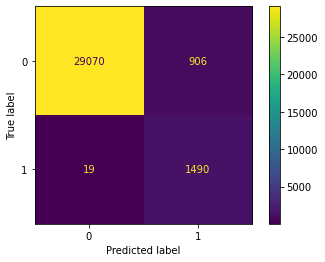

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot()

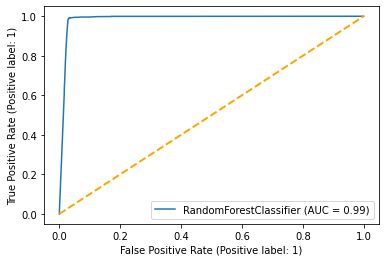

In [43]:
from sklearn.metrics import RocCurveDisplay
rfc_disp = RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test)
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')

# Learning Technique #2: Sliding window with undersampling in training only

In [44]:
df.reset_index(drop=True, inplace=True)

In [45]:
# Specify the features (X) and the target variable (y)
X = df.drop(["timestamp", 
             "u", 
             "v", 
             "history_type", 
             "bip", 
             "cost", # cost of O1 features
             "history_size",
             "is_fraud",], axis="columns")
y = df["is_fraud"]

In [46]:
X

,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
0,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,25.0,15.0,0.0,0.0,10.0,25.0,15.0,1.0,25.0,48.0,1.0,1.0,0.0,1.0,25.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
1,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,26.0,14.0,0.0,0.0,10.0,26.0,14.0,1.0,26.0,48.0,1.0,1.0,0.0,1.0,26.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
2,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,27.0,13.0,0.0,0.0,10.0,27.0,13.0,1.0,27.0,48.0,1.0,1.0,0.0,1.0,27.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
3,49.0,48.0,1.0,1.0,2.0,1.0,48.0,1.0,1.0,2.0,1.0,3.0,0.0,0.0,10.0,28.0,12.0,0.0,0.0,10.0,28.0,12.0,1.0,28.0,48.0,1.0,1.0,0.0,1.0,28.0,48.0,1.0,1.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
4,50.0,50.0,0.0,1.0,1.0,1.0,50.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,10.0,29.0,11.0,0.0,0.0,10.0,29.0,11.0,1.0,29.0,50.0,1.0,0.0,0.0,1.0,29.0,50.0,1.0,0.0,0.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104945,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,35.0,14.0,1.0,0.0,1.0,35.0,14.0,1.0,14.0,40.0,1.0,5.0,1.0,1.0,14.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104946,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,34.0,15.0,1.0,0.0,1.0,34.0,15.0,1.0,15.0,40.0,1.0,5.0,1.0,1.0,15.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104947,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,33.0,16.0,1.0,0.0,1.0,33.0,16.0,1.0,16.0,40.0,1.0,5.0,1.0,1.0,16.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104948,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,32.0,17.0,1.0,0.0,1.0,32.0,17.0,1.0,17.0,40.0,1.0,5.0,1.0,1.0,17.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


In [47]:
y

0         0
1         0
2         0
3         0
4         0
         ..
104945    0
104946    0
104947    0
104948    0
104949    0
Name: is_fraud, Length: 104950, dtype: int64

In [48]:
len(df) / 2

52475.0

In [49]:
8353+8350

16703

In [50]:
len(df)

104950

In [51]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

Delta: 1049 



In [52]:
len(df)

104950

In [53]:
# Parameters we can change
window_delta = 100
delta = int(len(df) / window_delta)
print("Delta:", delta, "\n")

roc_auc_results = []
c = 1

# Start the sliding window with overlap
for i in range(0, int(len(df) / 2), delta):
    b_i = i
    e_i = i + int(len(df) / 2)

    X_subset = X.iloc[b_i:e_i]
    y_subset = y.iloc[b_i:e_i]
    print(X_subset.index)

    X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, shuffle=False)

    # Undersample the majority class (0) within each window
    X_train_sampled = pd.concat([X_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), X_train[y_train == 1]])
    y_train_sampled = pd.concat([y_train[y_train == 0].sample(n=sum(y_train == 1), random_state=12), y_train[y_train == 1]])

    # Compute counts of y = 1 and y = 0 for y_train
    y_train_1_count = sum(y_train_sampled == 1)
    y_train_0_count = sum(y_train_sampled == 0)
    
    # Compute counts of y = 1 and y = 0 for y_test
    y_test_1_count = sum(y_test == 1)
    y_test_0_count = sum(y_test == 0)
    
    print(f"Iteration {c}:")
    print(f"Counts of y = 1 and y = 0 in y_train: {y_train_1_count}, {y_train_0_count}")
    print(f"Counts of y = 1 and y = 0 in y_test: {y_test_1_count}, {y_test_0_count}")
    c += 1
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train_sampled, y_train_sampled)
    y_pred = clf.predict(X_test)

    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

    roc_auc_results.append(roc_auc)
    print(b_i)
    print(f"Iteration difference {e_i - b_i}: ROC-AUC={roc_auc:.4f}")
    print("------------------------------------------------------------------------------------------------")

average_roc_auc = sum(roc_auc_results) / len(roc_auc_results)

print(f"Average ROC-AUC: {average_roc_auc:.4f}")


Delta: 1049 

RangeIndex(start=0, stop=52475, step=1)
Iteration 1:
Counts of y = 1 and y = 0 in y_train: 2044, 2044
Counts of y = 1 and y = 0 in y_test: 487, 10008
0
Iteration difference 52475: ROC-AUC=0.9850
------------------------------------------------------------------------------------------------
RangeIndex(start=1049, stop=53524, step=1)
Iteration 2:
Counts of y = 1 and y = 0 in y_train: 2047, 2047
Counts of y = 1 and y = 0 in y_test: 478, 10017
1049
Iteration difference 52475: ROC-AUC=0.9850
------------------------------------------------------------------------------------------------
RangeIndex(start=2098, stop=54573, step=1)
Iteration 3:
Counts of y = 1 and y = 0 in y_train: 2061, 2061
Counts of y = 1 and y = 0 in y_test: 477, 10018
2098
Iteration difference 52475: ROC-AUC=0.9877
------------------------------------------------------------------------------------------------
RangeIndex(start=3147, stop=55622, step=1)
Iteration 4:
Counts of y = 1 and y = 0 in y_train: 2057

28323
Iteration difference 52475: ROC-AUC=0.9872
------------------------------------------------------------------------------------------------
RangeIndex(start=29372, stop=81847, step=1)
Iteration 29:
Counts of y = 1 and y = 0 in y_train: 1964, 1964
Counts of y = 1 and y = 0 in y_test: 503, 9992
29372
Iteration difference 52475: ROC-AUC=0.9874
------------------------------------------------------------------------------------------------
RangeIndex(start=30421, stop=82896, step=1)
Iteration 30:
Counts of y = 1 and y = 0 in y_train: 1985, 1985
Counts of y = 1 and y = 0 in y_test: 490, 10005
30421
Iteration difference 52475: ROC-AUC=0.9855
------------------------------------------------------------------------------------------------
RangeIndex(start=31470, stop=83945, step=1)
Iteration 31:
Counts of y = 1 and y = 0 in y_train: 1988, 1988
Counts of y = 1 and y = 0 in y_test: 498, 9997
31470
Iteration difference 52475: ROC-AUC=0.9867
--------------------------------------------------

In [54]:
df.tail(2)

,timestamp,u,v,is_fraud,history_type,history_size,bip,cost,top_number_of_nodes,top_degrees_nb_one,top_degrees_nb_two,top_degrees_min,top_degrees_max,top_degrees_median,top_weighted_degrees_nb_one,top_weighted_degrees_nb_two,top_weighted_degrees_min,top_weighted_degrees_max,top_weighted_degrees_median,bot_number_of_nodes,bot_degrees_nb_one,bot_degrees_nb_two,bot_degrees_min,bot_degrees_max,bot_degrees_median,bot_weighted_degrees_nb_one,bot_weighted_degrees_nb_two,bot_weighted_degrees_min,bot_weighted_degrees_max,bot_weighted_degrees_median,u_degree,v_degree,u_same_degree,v_same_degree,u_greater_degree,v_greater_degree,u_weighted_degree,v_weighted_degree,u_same_weighted_degree,v_same_weighted_degree,u_greater_weighted_degree,v_greater_weighted_degree,number_of_links,total_weight,link_weights_nb_one,link_weights_nb_two,link_weights_min,link_weights_max,link_weights_median,u_v_weight,u_v_same_weight,u_v_greater_weight
104948,893286638,bottom_689,top_729,0,H,50,True,0.0,45.0,40.0,5.0,1.0,2.0,1.0,40.0,5.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,32.0,17.0,1.0,0.0,1.0,32.0,17.0,1.0,17.0,40.0,1.0,5.0,1.0,1.0,17.0,40.0,1.0,5.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0
104949,893286638,bottom_748,top_729,0,H,50,True,0.0,44.0,38.0,6.0,1.0,2.0,1.0,38.0,6.0,1.0,2.0,1.0,3.0,1.0,0.0,1.0,31.0,18.0,1.0,0.0,1.0,31.0,18.0,2.0,18.0,6.0,1.0,0.0,1.0,2.0,18.0,6.0,1.0,0.0,1.0,50.0,50.0,50.0,0.0,1.0,1.0,1.0,1.0,50.0,0.0


In [55]:
# Create a DataFrame
df2 = pd.DataFrame({"Values": roc_auc_results})

# Export DataFrame to Excel
df2.to_excel("MovieLens-5Perc-H50-AUCInSlidingWindow.xlsx", index=False)

In [56]:
len(roc_auc_results)

51

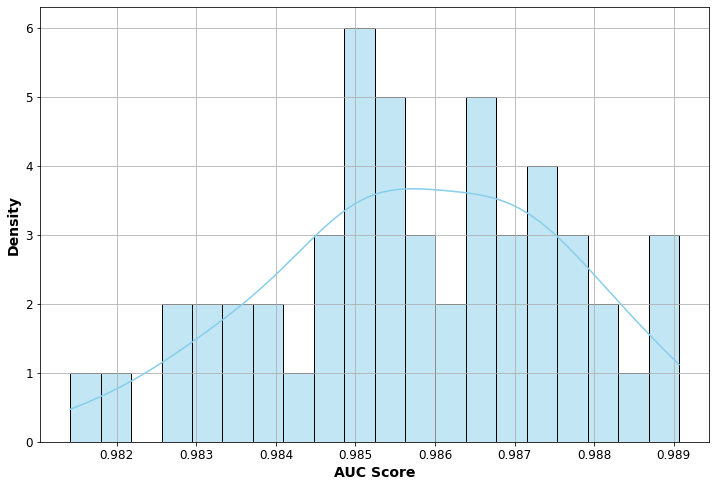

In [57]:
import seaborn as sns

# Plot the distribution with kernel density estimate
plt.figure(figsize=(12, 8))
sns.histplot(df2["Values"], kde=True, bins=20, color='skyblue')
plt.xlabel("AUC Score", fontsize=14,  fontweight='bold')
plt.ylabel("Density", fontsize=14,  fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()